In [7]:
# Na podstawie danych należy przewidzieć aktywność osoby za podstawie pomiarów z czujników.

# Analiza, oprócz wstępnej eksploracji danych, zaprojektowania modelu uczenia i wpływu pre-procesingu na wyniki, powinna obejmować następujące kwestie:

# 1. Czy lepiej dokonać predykcji dla konkretnych aktywności, czy wyrażając stopień aktywności jako liczbę rzeczywista z pewnego przedziału tak aby większa aktywność odpowiadała wyższej wartości? 

# 2. Czy lepiej stworzyć model globalny dla wszystkich uczestników czy osobny model dla każdej osoby?

# 3. Odpowiedzieć jak długość obserwacji czynności wpływa na jakość klasyfikacji.

# Uwagi ogólne:
# - Porównać przynajmniej trzy różne modele 
# - Sformułować wnioski aby były zrozumiałe dla eksperta dziedzinowego, który niekoniecznie rozumie uczenie maszynowe, wyjaśnić co wpływa na wynik predykcji.


In [8]:
# Zestaw danych zawiera dane 9 klas aktywności; 6 zajęć ruchowych oraz 3 zajęcia siedzące, wykonywane przez 33 uczestników.

# Dane są rejestrowane za pomocą dwóch trójosiowych akcelerometrów próbkujących z zegarem 100 Hz, zamontowanych na dominujący nadgarstek i udo uczestnika.  

# Nazwa pliku zawiera numer uczestnika oraz nazwę aktywności. Każdy plik posiada 6 kolumn:
# 1 -- wartość x nadgarstka
# 2 -- wartość y nadgarstka
# 3 -- wartość z nadgarstka
# 4 -- wartość x uda
# 5 -- wartość y uda
# 6 -- wartość z uda
# Wartość minimalna: -8
# Wartość maksymalna: +8



In [9]:
import pandas as pd
import numpy as np
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from mlxtend.evaluate import bootstrap_point632_score
from mlxtend.evaluate import BootstrapOutOfBag
from mlxtend.evaluate import bootstrap
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.linear_model import LinearRegression
import math

In [10]:
activities = [
    "downstairs",
    "jogging",
    "lying",
    "sitting",
    "standing",
    "upstairs",
    "walkfast",
    "walkmod",
    "walkslow",
]
# people = ["026", "027", "028", "029", "030", "031", "033", "034", "036", "039", "040", "041", "042", "043", "044", "046", "047", "048", "049", "050", "051", "052", "053", "054", "055", "056", "057", "058", "059", "060", "061", "062", "063"]
people = ["026", "027", "028", "029", "030", "031", "033", "034", "036", "039", "040"]

column_names = ["x_wrist", "y_wrist", "z_wrist", "x_thigh", "y_thigh", "z_thigh"]
# column_names = ["x_wrist", "y_wrist", "x_thigh", "y_thigh"]


def classifyBasedOnValue(val):
    if val < 1 / 9:
        return activities.index("lying")
    if val < 2 / 9:
        return activities.index("sitting")
    if val < 3 / 9:
        return activities.index("standing")
    if val < 4 / 9:
        return activities.index("walkslow")
    if val < 5 / 9:
        return activities.index("downstairs")
    if val < 6 / 9:
        return activities.index("walkmod")
    if val < 7 / 9:
        return activities.index("walkfast")
    if val < 8 / 9:
        return activities.index("upstairs")
    return activities.index("jogging")

def getValueBasedOnName(name):
    if name=="lying":
        return 1/9-1/18
    if name=="sitting":
        return 2/9-1/18
    if name=="standing":
        return 3/9-1/18
    if name=="walkslow":
        return 4/9-1/18
    if name=="downstairs":
        return 5/9-1/18
    if name=="walkmod":
        return 6/9-1/18
    if name=="walkfast":
        return 7/9-1/18
    if name=="upstairs":
        return 8/9-1/18
    if name=="jogging":
        return 1-1/18
    return -1


In [27]:

RANDOM_SEED = 42


def read_data_csv(person, activity):
    path = "./data/" + str(person) + "_" + str(activity) + ".csv"
    df = pd.read_csv(path,header=None)
    
    #df = df.drop(df.columns[[2,5]], axis=1)
    
    df.columns = column_names
    
    #df.drop("z_wrist", axis=1, inplace=True)
    #df.drop("z_thigh", axis=1, inplace=True)
    #df.drop('z_thigh', axis=1, inplace=True)    
    
    return df

def create_input_data_old(source_data_frame):
    rows_in_one_time_series = 300
    series_count = math.floor(len(source_data_frame.index) / rows_in_one_time_series) 
    
    column_count = len(column_names)
    
    data_array = np.zeros((series_count, rows_in_one_time_series * column_count))
    
    produced_column_names = list()
    for row_index in range(rows_in_one_time_series):
        for i in range(column_count):
            produced_column_names.append(column_names[i] + "_row_" + str(row_index))
    
    for entity_index in range(series_count):
        starting_index = series_count * rows_in_one_time_series
        for row_index in range(rows_in_one_time_series):
            for column_index in range(column_count):                
                data_array[entity_index, column_count * row_index + column_index] = source_data_frame[column_names[column_index]][entity_index * rows_in_one_time_series + row_index] 
            

    df = pd.DataFrame(data=data_array, index=range(series_count), columns=produced_column_names)
    
    return df

def create_input_data(source_data_frame):
    rows_in_one_time_series = 300

    current_offset = 0
    offset_change = 100
    
    series_count = math.floor((len(source_data_frame.index) - rows_in_one_time_series) / offset_change) + 1
    
    column_count = len(column_names)
    
    data_array = np.zeros((series_count, rows_in_one_time_series * column_count))
    
    produced_column_names = list()
    for row_index in range(rows_in_one_time_series):
        for i in range(column_count):
            produced_column_names.append(column_names[i] + "_row_" + str(row_index))  
    
    for entity_index in range(series_count):        
        
        #czytamy od curent_offset do current_offset+300
        
        for row_index in range(rows_in_one_time_series):
            for column_index in range(column_count):                
                data_array[entity_index, column_count * row_index + column_index] = source_data_frame[column_names[column_index]][current_offset + row_index] 
        current_offset += offset_change
            

    df = pd.DataFrame(data=data_array, index=range(series_count), columns=produced_column_names)
    
    return df     

def evaluate_results(classes_number, y_test, y_pred):
    cr = classification_report(
        y_test, 
        y_pred
    )
    print(cr)
    
    cm = confusion_matrix(
        y_test, 
        y_pred, 
        labels=range(classes_number)
    )
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=range(classes_number)
    )
    disp.plot()

def build_model_classifier(X_train, X_test, y_train, y_test, param_dict, class_number):

    clf = xgb.XGBClassifier(**param_dict)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    evaluate_results(class_number, y_test, y_pred)
    
    return clf

def build_model_regression(X_train, X_test, y_train, y_test, param_dict, class_number):

    clf = xgb.XGBRegressor(**param_dict)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred=pd.Series(y_pred)
    y_pred=y_pred.apply(classifyBasedOnValue)
    y_test=y_test.apply(classifyBasedOnValue)
    evaluate_results(class_number, y_test, y_pred)
    
    return clf


param_dict = {
    'objective':'binary:logistic',
    'use_label_encoder':False,
    'random_state':RANDOM_SEED
}

#clf = build_model_classifier(X_train, X_test, y_train, y_test, param_dict)


def create_input_data_for_activity(activity_index, classification=True):

    individual_dataframes = list()
    for person in people:
        person_df = read_data_csv(person, activities[activity_index])
        input_data_for_person = create_input_data(person_df)
        individual_dataframes.append(input_data_for_person)        
        
        print("activity: " + activities[activity_index] + ", person: " + person + " read, created " + str(len(input_data_for_person.index)) + " timeseries")
        
    concatenated_df = pd.concat(individual_dataframes)
    if classification==True:
        concatenated_df["Label"] = activity_index
    else:
        concatenated_df["Label"]=getValueBasedOnName(activities[activity_index])
    
    print("For activity: " + activities[activity_index] + " created total of " + str(len(concatenated_df.index)) + " timeseries")
    
    return concatenated_df



# przypisać etykiety do wierszy (szeregów czasowych)
# opcjonalnie: przetasować dane wejściowe
# podzielić na test/train

def create_input_data_for_multiple_activities(selected_activities, classification=True):
    
    individual_dataframes = list()
    for activity_index in selected_activities:
        df_for_activity = create_input_data_for_activity(activity_index, classification)
        individual_dataframes.append(df_for_activity)
    
    concatenated_df = pd.concat(individual_dataframes)
    print("Generated dataframe for multiple activities:")
    for activity_index in selected_activities:
        print(activities[activity_index])
        
    print("This dataframe contains a total of " + str(len(concatenated_df.index)) + " timeseries.")
    
    return concatenated_df

def create_input_data_for_one_person(person_index, selected_activities, classification=True):
    print("Creating input data for person [" + people[person_index] + "]")
    individual_dataframes = list()
    for activity_index in selected_activities:
        read_df = read_data_csv(people[person_index], activities[activity_index])
        input_data_for_person = create_input_data(read_df)
        if classification==True:        
            input_data_for_person["Label"] = activity_index
        else:
            input_data_for_person["Label"]=getValueBasedOnName(activities[activity_index])
        individual_dataframes.append(input_data_for_person)
        print("For person [" + people[person_index] + "]. Created " + str(len(input_data_for_person.index)) + "rows for activity: " + activities[activity_index])
        
    concatenated_df = pd.concat(individual_dataframes)
    
    print("Finished input data for person [" + people[person_index] + "]. Created summary of " + str(len(concatenated_df.index)) + "rows.")
    return concatenated_df

def split_dataset(df, test_size = 0.3):
    X_df = df.iloc[:,:-1]
    y_df = df["Label"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_df,
        y_df,
        test_size = test_size,
        random_state = RANDOM_SEED
    )
    
    return X_train, X_test, y_train, y_test


Creating input data for person [030]
For person [030]. Created 51rows for activity: downstairs
For person [030]. Created 290rows for activity: jogging
For person [030]. Created 173rows for activity: lying
For person [030]. Created 155rows for activity: sitting
For person [030]. Created 163rows for activity: standing
For person [030]. Created 59rows for activity: upstairs
For person [030]. Created 169rows for activity: walkfast
For person [030]. Created 168rows for activity: walkmod
For person [030]. Created 172rows for activity: walkslow
Finished input data for person [030]. Created summary of 1400rows.
[15:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.64

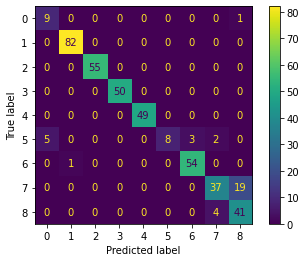

In [28]:
#policz dla jednej osoby
class_list=[0,1,2,3,4,5,6,7,8]
data_one_person = create_input_data_for_one_person(4, class_list, True)
X_train, X_test, y_train, y_test = split_dataset(data_one_person)
clf = build_model_classifier(X_train, X_test, y_train, y_test, param_dict, len(class_list))

Creating input data for person [030]
For person [030]. Created 51rows for activity: downstairs
For person [030]. Created 290rows for activity: jogging
For person [030]. Created 173rows for activity: lying
For person [030]. Created 155rows for activity: sitting
For person [030]. Created 163rows for activity: standing
For person [030]. Created 59rows for activity: upstairs
For person [030]. Created 169rows for activity: walkfast
For person [030]. Created 168rows for activity: walkmod
For person [030]. Created 172rows for activity: walkslow
Finished input data for person [030]. Created summary of 1400rows.
[15:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.05 

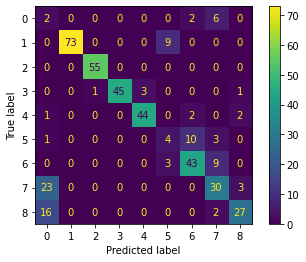

In [29]:
#policz dla jednej osoby
class_list=[0,1,2,3,4,5,6,7,8]
data_one_person = create_input_data_for_one_person(4, class_list, False)
X_train, X_test, y_train, y_test = split_dataset(data_one_person)
clf = build_model_regression(X_train, X_test, y_train, y_test, param_dict, len(class_list))

In [31]:
#policz dla wszystkich ludzi
class_list=[0,1,2]
input_data_all_people = create_input_data_for_multiple_activities(class_list, True)
X_train, X_test, y_train, y_test = split_dataset(input_data_all_people)
clf = build_model_classifier(X_train, X_test, y_train, y_test, param_dict, len(class_list))

activity: downstairs, person: 026 read, created 67 timeseries
activity: downstairs, person: 027 read, created 68 timeseries
activity: downstairs, person: 028 read, created 78 timeseries
activity: downstairs, person: 029 read, created 65 timeseries
activity: downstairs, person: 030 read, created 51 timeseries
activity: downstairs, person: 031 read, created 79 timeseries
activity: downstairs, person: 033 read, created 56 timeseries


In [ ]:
#policz dla wszystkich ludzi
class_list=[0,1,2]
input_data_all_people = create_input_data_for_multiple_activities(class_list, False)
X_train, X_test, y_train, y_test = split_dataset(input_data_all_people)
clf = build_model_regression(X_train, X_test, y_train, y_test, param_dict, len(class_list))